<a href="https://colab.research.google.com/github/songseunghei/DeepLearning/blob/main/Gradient_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2 as cv
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from google.colab.patches import cv2_imshow
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input,decode_predictions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model=ResNet50(weights = 'imagenet')
img = cv.imread('rabbit.jpg')

In [ ]:
img = cv.imread('/content/sample_data/rabbit.jpg')

In [ ]:
x=np.reshape(cv.resize(img,(224,224)),(1,224,224,3))
x=preprocess_input(x)
preds = model.predict(x)
top5=decode_predictions(preds,top=5)[0]
print('예측결과:',top5)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


예측결과: [('n02325366', 'wood_rabbit', 0.74275434), ('n02326432', 'hare', 0.24023634), ('n02328150', 'Angora', 0.008815733), ('n01877812', 'wallaby', 0.0026892442), ('n02356798', 'fox_squirrel', 0.0012279318)]


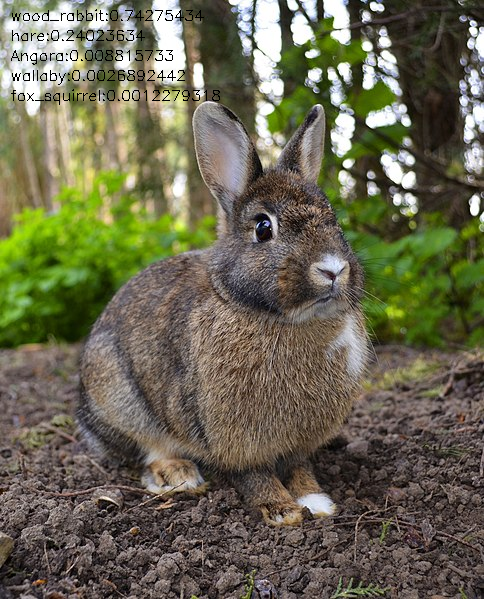

In [ ]:
for i in range(5):
  cv.putText(img,top5[i][1] + ':' + str(top5[i][2]),(10,20+i*20), cv.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),1)
cv2_imshow(img)

cv.waitKey()
cv.destroyAllWindows()

In [ ]:
model.summary()
np.argmax(preds[0])

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

330

In [ ]:
from keras import backend as K
wood_rabbit_output =model.output[:,330]
last_conv_layer_name="conv5_block3_out"
last_conv_layer =model.get_layer(last_conv_layer_name)

grads = K.gradients(wood_rabbit_output, last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0,1,2))
iterate =K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value=iterate([x])

In [ ]:
for i in range(2048):
  conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)


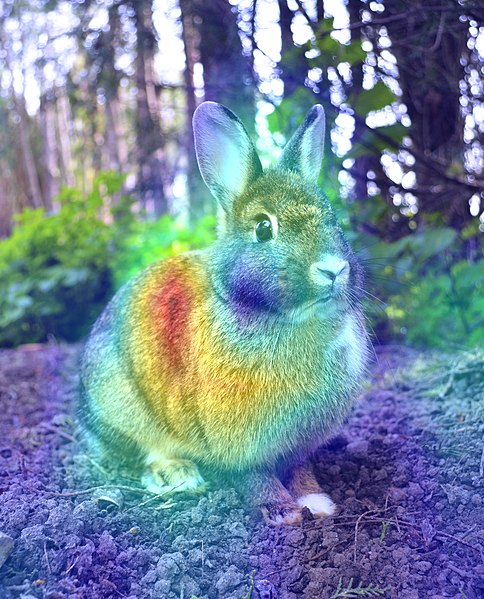

In [ ]:
img = cv.imread('/content/sample_data/rabbit.jpg')
heatmap = cv.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap=np.uint8(255*heatmap)
heatmap=cv.applyColorMap(heatmap,cv.COLORMAP_JET)
superimposed_img = heatmap * 0.4 +img
cv2_imshow(superimposed_img)